In [19]:
from ba import BA

dataset = BA()

In [20]:
from torch_geometric.loader import DataLoader
from ba import BA

dataset = BA()

train_set = BA(mode='training')
train_loader = DataLoader(train_set,
                            batch_size=16,
                            shuffle=True,
                            num_workers=16,
                            pin_memory=True,
                            drop_last=True)

val_set = BA(mode='evaluation')
val_loader = DataLoader(val_set)

test_set = BA(mode='testing')
test_loader = DataLoader(test_set)

In [21]:
import torch

device = torch.device('cuda')

In [22]:
from models import  GcnEncoderGraph

task_model = GcnEncoderGraph(input_dim=train_set.num_features,
                                     hidden_dim=20,
                                     embedding_dim=20,
                                     num_layers=4,
                                     pred_hidden_dims=[],
                                     label_dim=2)
task_model.to(device)

GcnEncoderGraph(
  (conv_first): GCNConv(10, 20)
  (conv_block): ModuleList(
    (0-1): 2 x GCNConv(20, 20)
  )
  (conv_last): GCNConv(20, 20)
  (act): ReLU()
  (pred_model): Linear(in_features=80, out_features=2, bias=True)
)

## Test task model

In [23]:
import torch

path = './params/ba2_net.pt'
task_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [24]:
from utils import evaluate_graphs_accuracy

evaluate_graphs_accuracy(train_loader, task_model), evaluate_graphs_accuracy(test_loader, task_model), evaluate_graphs_accuracy(val_loader, task_model)

(0.99125, 0.98, 1.0)

task model acc:

    (train, test, val): (0.99125, 0.98, 1.0)

In [25]:
from cider import CIDER

hidden_channels1 = 8
hidden_channels2 = 4
hidden_channels3 = 8

explainer_model = CIDER(train_set.num_features,
                                hidden_channels1=hidden_channels1,
                                hidden_channels2=hidden_channels2,
                                hidden_channels3=hidden_channels3,
                                task_model=task_model)

explainer_model.to(device)

CIDER(
  (gcn_shared): Sequential(
    (0): GCNConv(10, 8)
  )
  (gcn_mu_causal): GCNConv(8, 4)
  (gcn_mu_non_causal): GCNConv(8, 4)
  (gcn_logvar_causal): GCNConv(8, 4)
  (gcn_logvar_non_causal): GCNConv(8, 4)
  (decoder_causal): InnerProductDecoderMLP(
    (fc): Linear(in_features=4, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (decoder_non_causal): InnerProductDecoderMLP(
    (fc): Linear(in_features=4, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (task_model): GcnEncoderGraph(
    (conv_first): GCNConv(10, 20)
    (conv_block): ModuleList(
      (0-1): 2 x GCNConv(20, 20)
    )
    (conv_last): GCNConv(20, 20)
    (act): ReLU()
    (pred_model): Linear(in_features=80, out_features=2, bias=True)
  )
  (relu): ReLU()
)

In [26]:
lr = 1e-4

optimizer = torch.optim.Adam(explainer_model.parameters(),
                                lr=lr,
                                weight_decay=1e-5)

In [27]:
class DynamicObject:
    def __init__(self, **kwargs):
        # Initialize the object with any provided properties
        for key, value in kwargs.items():
            setattr(self, key, value)

args = DynamicObject()

In [28]:
from utils import train_one_epoch, validate
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

for epoch in range(0, 10):
    losses = train_one_epoch(train_loader, explainer_model, CrossEntropyLoss(), BCEWithLogitsLoss(), optimizer, task_model, epoch, args)

AttributeError: 'DynamicObject' object has no attribute 'random_sparsity'

## Overfit on a Small Subset without any trick

### Freeze task model

In [ ]:
for param in task_model.parameters():
    param.requires_grad = False

In [ ]:
args.N = 5
args.alpha_r = 1
args.alpha_c = 1
args.alpha_kld = 0.1
args.alpha_reg = 0
args.alpha_diff = 0
args.sparsity = 0.95
args.random_sparsity = False

Init Mini Batch 

In [ ]:
subset = train_set[0:10]

subset_loader = DataLoader(subset)

task_model.train()
explainer_model.train()

CIDER(
  (gcn_shared): Sequential(
    (0): GCNConv(10, 8)
  )
  (gcn_mu_causal): GCNConv(8, 4)
  (gcn_mu_non_causal): GCNConv(8, 4)
  (gcn_logvar_causal): GCNConv(8, 4)
  (gcn_logvar_non_causal): GCNConv(8, 4)
  (decoder_causal): InnerProductDecoderMLP(
    (fc): Linear(in_features=4, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (decoder_non_causal): InnerProductDecoderMLP(
    (fc): Linear(in_features=4, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (task_model): GcnEncoderGraph(
    (conv_first): GCNConv(10, 20)
    (conv_block): ModuleList(
      (0-1): 2 x GCNConv(20, 20)
    )
    (conv_last): GCNConv(20, 20)
    (act): ReLU()
    (pred_model): Linear(in_features=80, out_features=2, bias=True)
  )
  (relu): ReLU()
)

## check bp

In [ ]:
explainer_model.state_dict()['gcn_shared.module_0.lin.weight'][-1], task_model.state_dict()['conv_first.lin.weight'][-1], 

(tensor([-0.1275, -0.1146,  0.3030,  0.3292, -0.4885, -0.5172,  0.3497, -0.5198,
          0.0246, -0.4079], device='cuda:0'),
 tensor([-0.0056, -0.0059, -0.0059, -0.0056, -0.0056, -0.0056, -0.0056, -0.0056,
         -0.0056, -0.0057], device='cuda:0'))

In [ ]:
from utils import train_one_epoch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

for epoch in range(0, 100):
    losses = train_one_epoch(subset_loader, explainer_model, CrossEntropyLoss(), BCEWithLogitsLoss(), optimizer, task_model, epoch, args)
    print(losses['causal loss'], losses['reconstruction loss'], losses['causal diversity loss'], losses['total loss'], losses['train acc'])

53.045510412828385 1.5702825486660004 -0.5212759971618652 54.68864947557449 0.5
52.88030561022242 1.5677532404661179 -0.5208928287029266 54.52086068689823 0.5
57.00258273354177 1.549373373389244 -0.5205082595348358 58.62470296025276 0.5
50.60074598527717 1.5639783889055252 -0.5201201438903809 52.23741392791271 0.52
59.90585582838912 1.560311809182167 -0.5197277963161469 61.53880004584789 0.5
57.79342977142733 1.5436295568943024 -0.5193297564983368 59.409633964300156 0.5
51.49952785300138 1.56022909283638 -0.518926739692688 53.13227641582489 0.5
48.775599032419265 1.5334022045135498 -0.5185245871543884 50.38146285712719 0.48
52.63500768169445 1.550582766532898 -0.5181149542331696 54.25799226760864 0.5
54.166080971432166 1.577727347612381 -0.517704427242279 55.8161495923996 0.5
47.36778524944111 1.551014006137848 -0.5172875821590424 48.99108085036278 0.5
53.82352685442311 1.5467169731855392 -0.5168735682964325 55.44246615469456 0.5
55.68327666871005 1.5612609535455704 -0.5164508819580078

In [ ]:
explainer_model.state_dict()['gcn_shared.module_0.lin.weight'][-1], task_model.state_dict()['conv_first.lin.weight'][-1], 

(tensor([-7.4707e-02, -6.2644e-02,  2.4591e-01,  2.7185e-01, -4.3025e-01,
         -4.5888e-01,  2.9220e-01, -4.6142e-01,  3.0209e-04, -3.5008e-01],
        device='cuda:0'),
 tensor([-0.0056, -0.0059, -0.0059, -0.0056, -0.0056, -0.0056, -0.0056, -0.0056,
         -0.0056, -0.0057], device='cuda:0'))

### testing task model

In [ ]:
from utils import evaluate_graphs_accuracy

evaluate_graphs_accuracy(subset_loader, task_model)

In [ ]:
from utils import validate

validate(subset, explainer_model, task_model, batch_size=8)

## check the result of separation

In [33]:
explainations = explainer_model.get_explainations(subset[0].x.cuda(), subset[0].edge_index.cuda())

In [ ]:
subset[0].edge_index, subset[0].edge_index.shape

In [ ]:
explainations['0.9'].edge_index, explainations['0.9'].edge_index.shape

In [ ]:
from utils import evaluate_graphs_accuracy

evaluate_graphs_accuracy(train_loader, task_model, require_cm=True)

In [ ]:
evaluate_graphs_accuracy(train_loader, task_model), evaluate_graphs_accuracy(test_loader, task_model), evaluate_graphs_accuracy(val_loader, task_model)

In [ ]:
dataset[0].y, dataset[1].y

In [ ]:
task_model(torch.rand_like(dataset[0].x).to(device), torch.tensor([[], []]).to(torch.long).to(device)), task_model(torch.rand_like(dataset[0].x).to(device), torch.tensor([[], []]).to(torch.long).to(device)).argmax(dim=1).item()

In [ ]:
task_model(torch.rand_like(dataset[0].x).to(device), data.edge_index.to(device)), task_model(torch.rand_like(dataset[0].x).to(device), data.edge_index.to(device)).argmax(dim=1).item()

In [ ]:
index = 0
task_model(dataset[index].x.to(device), dataset[index].edge_index.to(device)), task_model(dataset[index].x.to(device), dataset[index].edge_index.to(device)).argmax(dim=1).item()

In [ ]:
index = 100
task_model(train_set[index].x.to(device), train_set[index].edge_index.to(device)), task_model(train_set[index].x.to(device), train_set[index].edge_index.to(device)).argmax(dim=1).item()

In [30]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import barabasi_albert_graph

num_nodes = 5
num_edges = 2
ba_data = barabasi_albert_graph(num_nodes, num_edges)

In [79]:
subset[0].edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  3,  4,
          5,  5,  5,  5,  5,  6,  7,  8,  9, 10, 11, 11, 12, 13, 14, 15, 15, 16,
         17, 18, 19, 20, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  2,  3,  4,  5,  6,  8, 10, 15, 17, 18, 20,  0,  9, 12,  0,  0,  0,
          0,  7, 11, 14, 16,  0,  5,  0,  1,  0,  5, 13,  1, 11,  5,  0, 19,  5,
          0,  0, 15,  0, 21, 24, 20, 22, 21, 23, 22, 24, 20, 23]])

In [ ]:
import torch
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Example PyG data object (replace this with your own data)
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)
data = torch_geometric.data.Data(edge_index=ba_data)

# Convert PyG data to NetworkX graph
graph = to_networkx(data)

# Visualize the graph using NetworkX
pos = nx.spring_layout(graph, seed=42)  # You can choose other layout algorithms
nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10, edge_color='gray')

plt.show()

/share/home/zhangqibin/anaconda3/envs/cider/lib/python3.11/site-packages/torch_geometric/data/storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


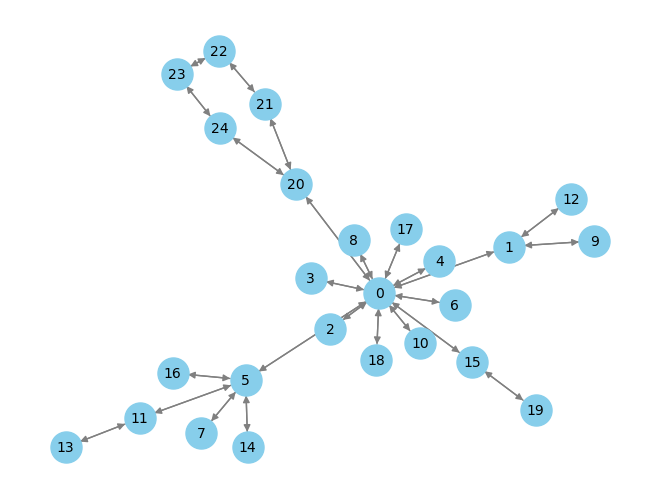

In [80]:
# Example PyG data object (replace this with your own data)
index = 0

data = torch_geometric.data.Data(edge_index=subset[index].edge_index)

# Convert PyG data to NetworkX graph
graph = to_networkx(data)

# Visualize the graph using NetworkX
pos = nx.spring_layout(graph, seed=42)  # You can choose other layout algorithms
nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10, edge_color='gray')

plt.show()

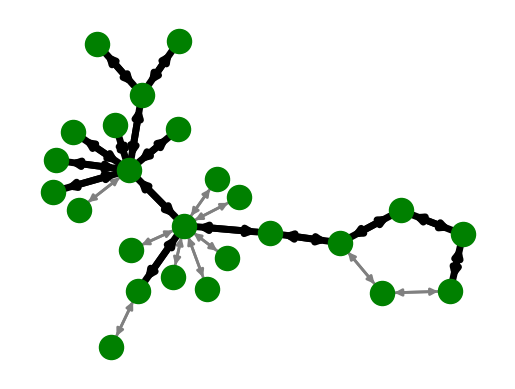

<Figure size 640x480 with 0 Axes>

In [75]:
import networkx as nx

index = 3

explainations = explainer_model.get_explainations(subset[index].x.cuda(), subset[index].edge_index.cuda())

explaination = to_networkx(explainations['0.5'])
G = torch_geometric.utils.to_networkx(subset[index])
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=[i for i in range(subset[index].num_nodes)], node_color='green', node_size=300)

nx.draw_networkx_edges(G, pos, width=2, edge_color='grey')

nx.draw_networkx_edges(G, pos, edgelist=explaination.edges, width=5)

plt.axis('off')
plt.show()
plt.clf()

In [ ]:
import torch
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif
from torch_geometric.datasets.motif_generator import CycleMotif

dataset1 = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=25, num_edges=1),
    motif_generator=HouseMotif(),
    num_motifs=1,
    num_graphs=500,
)

dataset2 = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=25, num_edges=1),
    motif_generator=CycleMotif(5),
    num_motifs=1,
    num_graphs=500,
)

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])
loader = DataLoader(dataset)

In [ ]:
evaluate_graphs_accuracy(loader, task_model)

## using vgae to fit BA-shape

In [ ]:
from torch_geometric.utils import barabasi_albert_graph
from torch_geometric.data import Data, Dataset
import torch

edge_indexes = [barabasi_albert_graph(10, 1) for i in range(10)]

num_nodes = 20

data_list = [Data(x=torch.ones([num_nodes, 10])/10, edge_index=barabasi_albert_graph(num_nodes, 1)) for i in range(10)]

In [ ]:
from torch_geometric.nn import VGAE, GraphConv
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, act=F.relu):
        super(Encoder, self).__init__()
        self.gcn_shared = GraphConv(input_dim, hidden_dim)
        self.gcn_z_mean = GraphConv(hidden_dim, latent_dim)
        self.gcn_z_log_var = GraphConv(hidden_dim, latent_dim)
        self.act = act

    def forward(self, x, edge_index):
        hidden = self.act(self.gcn_shared(x, edge_index))
        z_mean = self.gcn_z_mean(hidden, edge_index)
        z_log_var = self.gcn_z_log_var(hidden, edge_index)
        
        return z_mean, z_log_var

In [ ]:
vgae = VGAE(encoder=Encoder(10, 8, 2))

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(vgae.parameters(), lr=0.001)

In [ ]:
criterion = nn.BCELoss()

num_epochs = 300

for epoch in range(num_epochs):
    for data in data_list:
        optimizer.zero_grad()
        z = vgae.encode(data.x, data.edge_index)
        recons = vgae.decode(z, data.edge_index)
        loss_rec = 5*criterion(recons, torch.ones_like(recons)) 
        loss_kld = vgae.kl_loss()
        loss = loss_rec + loss_kld
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Loss_rec: {loss_rec.item()}, Loss_kld: {loss_kld.item()}")


In [ ]:
criterion(torch.ones([40])*0.53, torch.ones([40]))

## using vgae to fit motif